<a href="https://colab.research.google.com/github/ashika-06/NYC-Taxi-Demand-Prediction/blob/main/TAXIDEMAND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install "dask[complete]" pandas numpy

!pip install matplotlib seaborn folium

!pip install scikit-learn xgboost

!pip install notebook jupyterlab


# **New York City Taxi Demand Prediction**

## **1. Problem Statement**
For a taxi driver in New York City, efficiency is key. To maximize earnings and minimize idle time, a driver needs to know: *"In the next 10 minutes, how many pickup requests can I expect in my current region or neighboring regions?"*

Our goal is to predict the number of pickups for a specific region within a **10-minute time interval** (as the approximate time to cover a mile in NYC is 10-min).

## **2. Objectives & Constraints**
* **End-User:** A taxi driver using a smartphone app.
* **Goal:** Provide accurate demand forecasts to guide drivers to high-demand areas.
* **Latency Constraint:** The model must provide results with low latency (within a few seconds) to be usable in real-time.

## **3. Data Scope**
To focus our analysis on the most relevant data, we apply the following filters:
* **Taxi Type:** **Yellow Taxis** only (ignoring Green taxis and For-Hire Vehicles).
* **Time Period:** Data from **January 2015** and **January 2016 to March 2016**.

## **4. Evaluation Metric: Why Relative (Percentage) Error?**
We prioritize **Percentage Error** (like MAPE) over Absolute Error (MSE/MAE) because the volume of rides varies drastically between regions. An absolute error of 2 pickups means something very different depending on the location's busyness.

**Example:**
* **Case A (Busy Region):** Actual = 100, Predicted = 102.
    * Absolute Error: 2
    * Percentage Error: **2%** (Very accurate)
* **Case B (Quiet Region):** Actual = 10, Predicted = 12.
    * Absolute Error: 2
    * Percentage Error: **20%** (Significant error)

While the absolute error is the same (2), the performance in Case B is much worse. Percentage error captures this distinction, ensuring our model performs well across both busy and quiet zones.

## **5. Data Handling: Why Dask?**
The NYC Taxi & Limousine Commission dataset is massive.
* **The Challenge:** The total dataset size exceeds contains CSV files ranging from **1.9GB to 2.5GB**. Standard libraries like `pandas` attempt to load the entire file into RAM, which will cause the system to crash (Out of Memory error).
* **The Solution:** We use **Dask**.
    * Dask processes data **"block by block"** (lazy evaluation).
    * It loads a chunk into RAM, processes it, clears the memory, and then loads the next chunk.
    * This allows us to handle datasets significantly larger than our available RAM.

In [ ]:
from google.colab import files
files.upload()


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d elemento/nyc-yellow-taxi-trip-data


Dataset URL: https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data
License(s): U.S. Government Works
nyc-yellow-taxi-trip-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q nyc-yellow-taxi-trip-data.zip -d /content/nyc_taxi


# **Dataset Features**

| Field Name | Description |
| :--- | :--- |
| **VendorID** | A code indicating the TPEP provider that provided the record.<br>• **1:** Creative Mobile Technologies<br>• **2:** VeriFone Inc. |
| **tpep_pickup_datetime** | The date and time when the meter was engaged. |
| **tpep_dropoff_datetime** | The date and time when the meter was disengaged. |
| **Passenger_count** | The number of passengers in the vehicle (driver-entered value). |
| **Trip_distance** | The elapsed trip distance in miles reported by the taximeter. |
| **Pickup_longitude** | Longitude where the meter was engaged. |
| **Pickup_latitude** | Latitude where the meter was engaged. |
| **RateCodeID** | The final rate code in effect at the end of the trip.<br>• **1:** Standard rate<br>• **2:** JFK<br>• **3:** Newark<br>• **4:** Nassau or Westchester<br>• **5:** Negotiated fare<br>• **6:** Group ride |
| **Store_and_fwd_flag** | Indicates whether the trip record was held in vehicle memory before sending to the vendor (aka “store and forward”).<br>• **Y:** Store and forward trip<br>• **N:** Not a store and forward trip |
| **Dropoff_longitude** | Longitude where the meter was disengaged. |
| **Dropoff_latitude** | Latitude where the meter was disengaged. |
| **Payment_type** | A numeric code signifying how the passenger paid for the trip.<br>• **1:** Credit card<br>• **2:** Cash<br>• **3:** No charge<br>• **4:** Dispute<br>• **5:** Unknown<br>• **6:** Voided trip |
| **Fare_amount** | The time-and-distance fare calculated by the meter. |
| **Extra** | Miscellaneous extras and surcharges. Currently includes the **$0.50** and **$1** rush hour and overnight charges. |
| **MTA_tax** | **$0.50** MTA tax that is automatically triggered based on the metered rate in use. |
| **Tip_amount** | Tip amount. This field is automatically populated for **credit card** tips. **Cash tips are not included.** |
| **Improvement_surcharge** | **$0.30** improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| **Tolls_amount** | Total amount of all tolls paid in the trip. |
| **Total_amount** | The total amount charged to passengers. **Does not include cash tips.** |

# **ML Problem Formulation**

## **1. Time-Series Forecasting**
We predict the number of pickups $P$ at time $t+1$ based on historical data up to time $t$.
$$P_{t+1} = f(P_t, P_{t-1}, \dots, P_{t-k})$$

## **2. Performance Metrics**

### **Mean Squared Error (MSE)**
$$MSE = \frac{1}{n} \sum_{i=1}^{n} (A_i - P_i)^2$$
* **Why it is insufficient:** MSE penalizes absolute errors equally. An error of 5 pickups is treated the same whether the true demand is 5 (huge error) or 500 (negligible error).

### **Mean Absolute Percentage Error (MAPE) - *Priority Metric***
$$MAPE = \frac{1}{n} \sum_{t=1}^{n} \frac{|A_t - P_t|}{A_t} \times 100$$
* **Why we use it:** MAPE measures **relative error**. It ensures that our model is penalized more for missing small demands (e.g., predicting 12 instead of 10 is a 20% error) compared to large demands (e.g., predicting 102 instead of 100 is only a 2% error).

In [ ]:
import dask.dataframe as dd

ddf = dd.read_csv("/content/nyc_taxi/*.csv")

print(ddf.columns)

print(ddf.head())


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.3

In [ ]:
import glob

csv_files = glob.glob("/content/nyc_taxi/*.csv")
print(csv_files)


['/content/nyc_taxi/yellow_tripdata_2016-02.csv', '/content/nyc_taxi/yellow_tripdata_2015-01.csv', '/content/nyc_taxi/yellow_tripdata_2016-01.csv', '/content/nyc_taxi/yellow_tripdata_2016-03.csv']


In [ ]:
month= dd.read_csv('/content/nyc_taxi/yellow_tripdata_2015-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


# **Data Cleaning & Outlier Removal**

## **1. Spatial Filtering (Coordinate Check)**
We first validate the geographical data to ensure all pickup and drop-off coordinates lie within the **New York City** boundaries.
* **Action:** Filter out any data points where latitude/longitude values fall outside the NYC limits.

## **2. Trip Duration Analysis**
We analyze the `trip_duration` to identify impossible or erroneous records (e.g., negative duration or trips lasting hundreds of hours).

* **Initial Observation:** The raw box-plot is highly irregular due to extreme outliers, making it difficult to interpret.
* **Percentile Check:** To find a logical cutoff, we analyze the distribution at the upper extremes:
    * **90th to 100th percentile:** Identifies the broad range of outliers.
    * **99th to 100th percentile:** Zooms in on the most extreme values.
* **Threshold Selection:** We select the **99th percentile** value as our upper limit.
    * **Reasoning:** Since 99% of all valid trips fall within this duration, values above this threshold are statistically likely to be outliers/errors rather than genuine taxi rides.
* **Final Verification:** After applying this filter, we plot the box-plot again to confirm a clean and representative distribution.

In [ ]:
# Filtering for outliers based on latitude/longitude boundaries
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774) | \
                           (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]

!pip install folium
import folium

In [ ]:

outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774) | \
                           (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]


map_osm = folium.Map(location=[40.734695, -73.990372], tiles='CartoDB positron')


sample_locations = outlier_locations.head(10000)

for i, j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'], j['pickup_longitude']))).add_to(map_osm)

map_osm

Static preview. Run the code cell above to interact with the map.
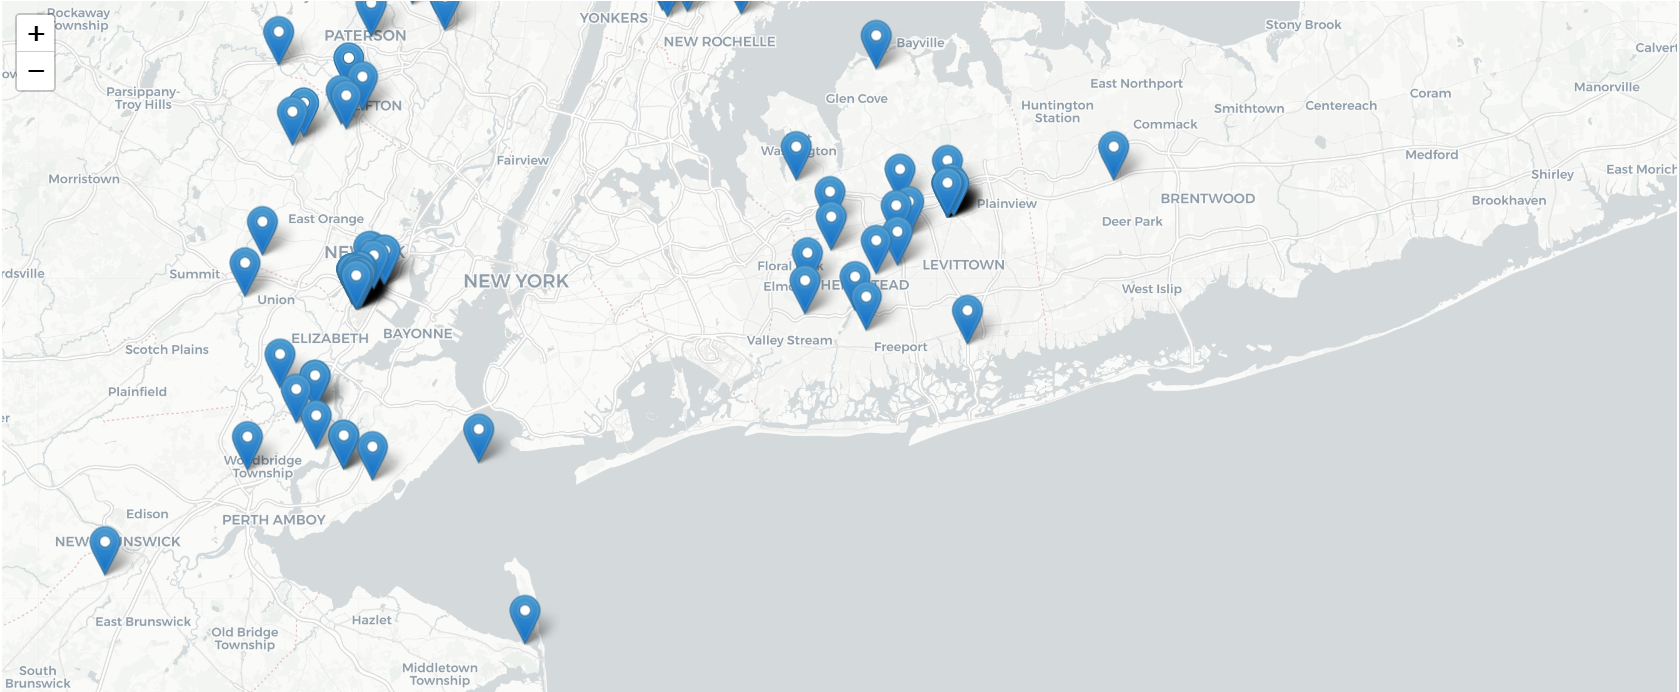

In [ ]:
import folium

# Filtering for outliers based on DROPOFF latitude/longitude boundaries

outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774) | \
                           (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='CartoDB positron')

sample_locations = outlier_locations.head(10000)

for i, j in sample_locations.iterrows():
    if int(j['dropoff_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'], j['dropoff_longitude']))).add_to(map_osm)

map_osm

Static preview. Run the code cell above to interact with the map.
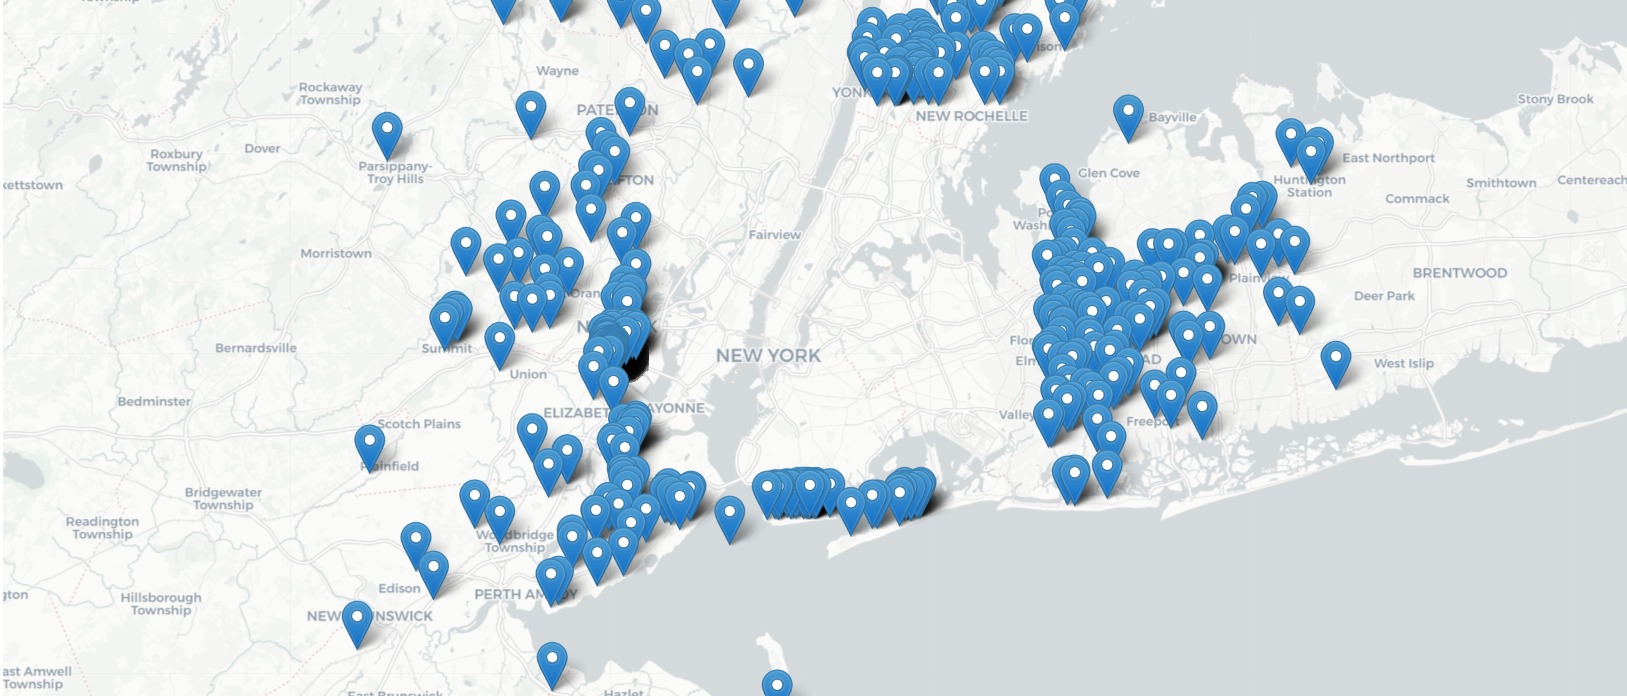

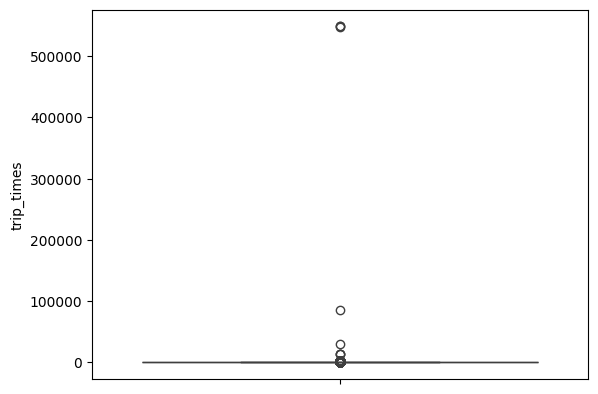

In [ ]:
import dask.dataframe as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read CSV with Dask
month = dd.read_csv('/content/nyc_taxi/yellow_tripdata_2015-01.csv',
                    usecols=['passenger_count','trip_distance','pickup_longitude','pickup_latitude',
                             'dropoff_longitude','dropoff_latitude','total_amount',
                             'tpep_pickup_datetime','tpep_dropoff_datetime'],
                    parse_dates=['tpep_pickup_datetime','tpep_dropoff_datetime'],
                    assume_missing=True)  # Helps Dask handle missing values efficiently

def return_with_trip_times_dask(df):

    df['trip_times'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

    df['Speed'] = 60 * (df['trip_distance'] / df['trip_times'])

    df['pickup_times'] = df['tpep_pickup_datetime'].astype(np.int64) // 10**9

    final_cols = ['passenger_count','trip_distance','pickup_longitude','pickup_latitude',
                  'dropoff_longitude','dropoff_latitude','total_amount','trip_times','pickup_times','Speed']
    return df[final_cols]


frame_with_durations = return_with_trip_times_dask(month)


sample = frame_with_durations.sample(frac=0.05).compute()  # 5% sample, converted to Pandas

sns.boxplot(y="trip_times", data=sample)
plt.show()


In [ ]:
import numpy as np

var = frame_with_durations["trip_times"].compute().values

for i in range(0, 101, 10):
    print(f"{i} percentile value is {np.percentile(var, i)}")


0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is 548555.6333333333


In [ ]:
import numpy as np

var = frame_with_durations["trip_times"].compute().values

for i in range(90, 101):
    print(f"{i} percentile value is {np.percentile(var, i)}")


90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is 548555.6333333333


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# filter durations
frame_filtered = frame_with_durations[
    (frame_with_durations["trip_times"] > 1) &
    (frame_with_durations["trip_times"] < 720)
]


In [ ]:
frame_filtered_pd = frame_filtered.compute()


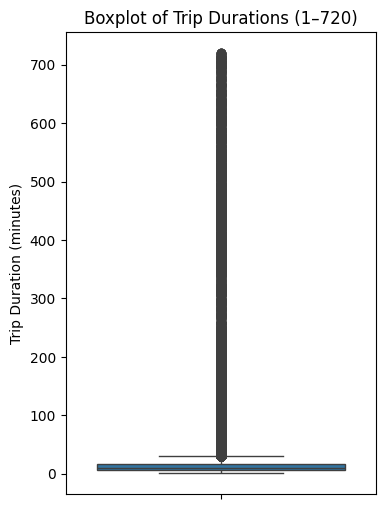

In [ ]:
plt.figure(figsize=(4, 6))
sns.boxplot(y=frame_filtered_pd["trip_times"])
plt.ylabel("Trip Duration (minutes)")
plt.title("Boxplot of Trip Durations (1–720)")
plt.show()


# **Distribution Check: Is it Gaussian?**

We analyze the **log-transformed trip durations** to see if they follow a **Normal (Gaussian) Distribution**.

### **1. Why do we check this?**
Many Machine Learning algorithms (like Linear Regression) perform significantly better when features are normally distributed. Since raw trip duration is highly skewed (many short trips, few very long ones), we apply a **Log-Transform** to make it more "model-friendly."

### **2. Observations**
* **PDF Plot:** The curve forms a clear "bell shape," suggesting the data approximates a Log-Normal distribution.
* **Q-Q Plot:** The sample points (blue) closely follow the theoretical normal line (red) in the center.

### **3. Why is it not perfectly Normal?**
You will notice deviations at the **tails** (ends) of the Q-Q plot.
* **Reason:** Real-world taxi data is influenced by external factors like traffic lights, road blocks, and human behavior, which creates "heavy tails" that a pure mathematical distribution cannot capture.

### **Takeaway**
Even though it is not perfectly Gaussian, the log-transformed data is much closer to a normal distribution than the raw data. This transformation effectively handles the skewness and is sufficient for our modeling needs.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

log_trip_times = np.log(frame_filtered_pd["trip_times"])


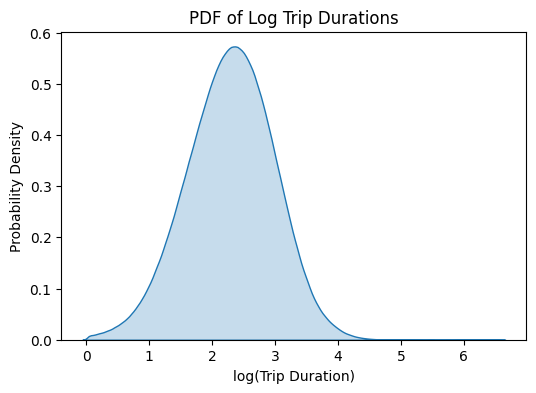

In [ ]:
plt.figure(figsize=(6, 4))
sns.kdeplot(log_trip_times, fill=True)
plt.xlabel("log(Trip Duration)")
plt.ylabel("Probability Density")
plt.title("PDF of Log Trip Durations")
plt.show()


In [ ]:
import numpy as np

log_trip_times = np.log(frame_filtered_pd["trip_times"])


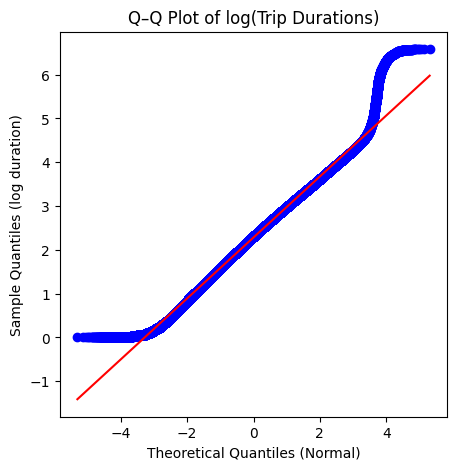

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.figure(figsize=(5, 5))
stats.probplot(log_trip_times, dist="norm", plot=plt)
plt.title("Q–Q Plot of log(Trip Durations)")
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Sample Quantiles (log duration)")
plt.show()


# **3. Cleaning Speed, Distance, and Fares**

After filtering trip durations, we apply a similar outlier detection strategy to **Speed** and **Trip Distance**, but we adapt our approach for **Total Fare**.

### **A. Speed & Trip Distance (Percentile Method)**
We repeat the percentile analysis (90th to 100th) used for duration.
* **Goal:** Remove physically impossible data points (e.g., cars flying at 500 mph or trips with 0 distance).
* **Threshold:** We calculate the 99th/99.9th percentile to determine a logical cutoff for maximum speed and distance.

### **B. Total Fare (Visual "Elbow" Method)**
For `Total_amount`, the standard percentile method proved insufficient.
* **The Issue:** The 99th percentile value was too low, risking the removal of valid, high-fare trips.
* **The Solution:** We visually inspect the **last 50 sorted values** and look for a sudden rise or "elbow." We set our threshold at this point to keep high-value trips while cutting off disconnected anomalies.

### **C. Final Consolidation**
Once all thresholds are determined, we apply the filters simultaneously.
* **Action:** We exclude all rows that fail the duration, speed, distance, or fare checks.
* **Result:** The remaining valid data is stored in a new **Cleaned DataFrame**, which serves as the foundation for our clustering and modeling steps.

In [ ]:
import numpy as np

frame_speed = frame_with_durations[
    (frame_with_durations["trip_times"] > 1) &
    (frame_with_durations["trip_times"] < 720)
].copy()

frame_speed["speed_miles_per_10min"] = (
    60 * frame_speed["trip_distance"] / frame_speed["trip_times"]
)


In [ ]:
frame_speed_pd = frame_speed.compute()


In [ ]:
import numpy as np


speed = frame_speed_pd["speed_miles_per_10min"].values


In [ ]:

percentiles = np.arange(90, 101)  # 90, 91, ..., 100

for p in percentiles:
    value = np.percentile(speed, p)
    print(f"{p}th percentile speed = {value:.3f} miles per 10 minutes")


90th percentile speed = 20.187 miles per 10 minutes
91th percentile speed = 20.916 miles per 10 minutes
92th percentile speed = 21.753 miles per 10 minutes
93th percentile speed = 22.722 miles per 10 minutes
94th percentile speed = 23.844 miles per 10 minutes
95th percentile speed = 25.183 miles per 10 minutes
96th percentile speed = 26.809 miles per 10 minutes
97th percentile speed = 28.843 miles per 10 minutes
98th percentile speed = 31.591 miles per 10 minutes
99th percentile speed = 35.751 miles per 10 minutes
100th percentile speed = 192857142.857 miles per 10 minutes


In [ ]:
# Filter speeds within desired range
speed_filtered = speed[(speed > 0) & (speed < 45.3)]
print(f"Number of trips in filtered range: {len(speed_filtered)}")


Number of trips in filtered range: 12607286


In [ ]:

avg_speed_10min = speed_filtered.mean()

avg_speed_per_min = avg_speed_10min / 10

print(f"Average speed (filtered 0 < speed < 45.3) = {avg_speed_10min:.3f} miles per 10 minutes")
print(f"Average speed (filtered 0 < speed < 45.3) = {avg_speed_per_min:.3f} miles per minute")


Average speed (filtered 0 < speed < 45.3) = 12.452 miles per 10 minutes
Average speed (filtered 0 < speed < 45.3) = 1.245 miles per minute


In [ ]:

distance = frame_speed_pd["trip_distance"].values


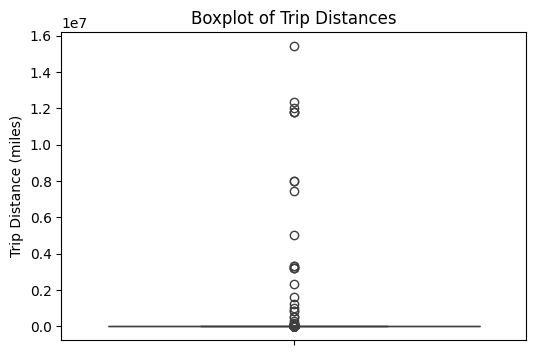

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(y=distance)
plt.ylabel("Trip Distance (miles)")
plt.title("Boxplot of Trip Distances")
plt.show()


In [ ]:
import numpy as np

for i in range(0, 101, 10):
    print(f"{i}th percentile distance = {np.percentile(distance, i):.3f} miles")


0th percentile distance = 0.000 miles
10th percentile distance = 0.670 miles
20th percentile distance = 0.900 miles
30th percentile distance = 1.100 miles
40th percentile distance = 1.390 miles
50th percentile distance = 1.700 miles
60th percentile distance = 2.080 miles
70th percentile distance = 2.610 miles
80th percentile distance = 3.600 miles
90th percentile distance = 6.000 miles
100th percentile distance = 15420004.500 miles


In [ ]:
for i in range(90, 101):
    print(f"{i}th percentile distance = {np.percentile(distance, i):.3f} miles")


90th percentile distance = 6.000 miles
91th percentile distance = 6.500 miles
92th percentile distance = 7.100 miles
93th percentile distance = 7.910 miles
94th percentile distance = 8.800 miles
95th percentile distance = 9.700 miles
96th percentile distance = 10.700 miles
97th percentile distance = 12.300 miles
98th percentile distance = 16.290 miles
99th percentile distance = 18.230 miles
100th percentile distance = 15420004.500 miles


In [ ]:
distance_filtered = distance[(distance > 0) & (distance < 22.5)]
print(f"Number of trips in filtered range: {len(distance_filtered)}")


Number of trips in filtered range: 12604664


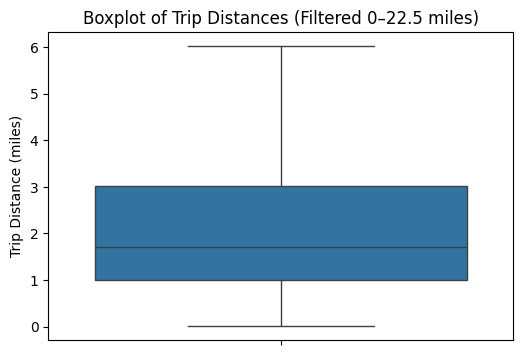

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=distance_filtered, showfliers=False)
plt.ylabel("Trip Distance (miles)")
plt.title("Boxplot of Trip Distances (Filtered 0–22.5 miles)")
plt.show()


In [ ]:
import numpy as np

total_amount = frame_with_durations["total_amount"].compute().values
percentiles_90_100 = np.arange(90, 101)

for p in percentiles_90_100:
    value = np.percentile(total_amount, p)
    print(f"{p}th percentile total_amount = {value:.2f}")


90th percentile total_amount = 26.00
91th percentile total_amount = 27.80
92th percentile total_amount = 29.75
93th percentile total_amount = 32.30
94th percentile total_amount = 35.60
95th percentile total_amount = 39.17
96th percentile total_amount = 43.36
97th percentile total_amount = 49.80
98th percentile total_amount = 58.13
99th percentile total_amount = 68.13
100th percentile total_amount = 3950611.60


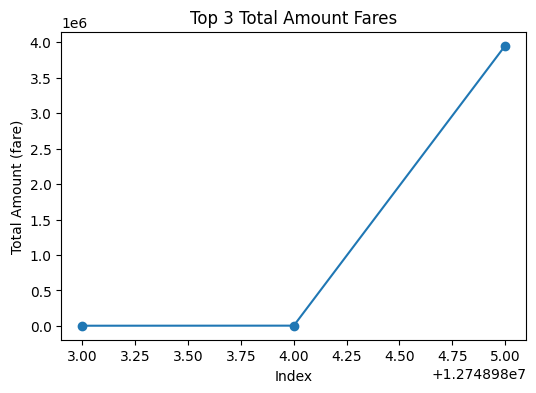

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


total_amount = frame_with_durations["total_amount"].compute().values
total_amount_sorted = np.sort(total_amount)  # ascending order


top3_values = total_amount_sorted[-3:]
top3_indices = np.arange(len(total_amount_sorted)-3, len(total_amount_sorted))  # their indices


plt.figure(figsize=(6, 4))
plt.plot(top3_indices, top3_values, marker='o')
plt.xlabel("Index")
plt.ylabel("Total Amount (fare)")
plt.title("Top 3 Total Amount Fares")
plt.show()


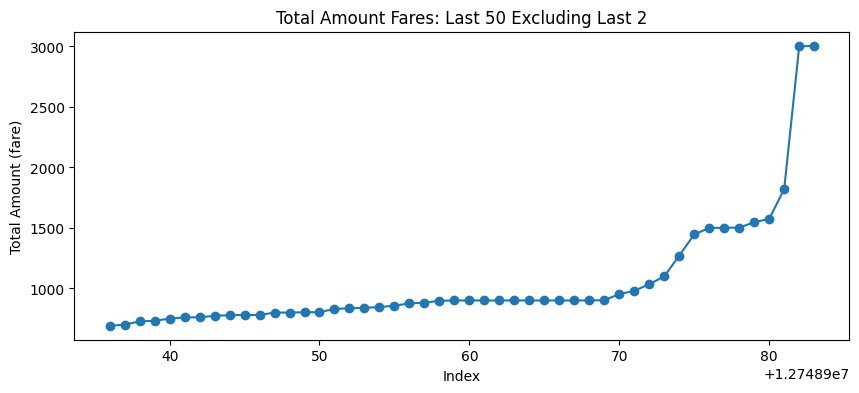

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


total_amount = frame_with_durations["total_amount"].compute().values
total_amount_sorted = np.sort(total_amount)


subset_values = total_amount_sorted[-50:-2]
subset_indices = np.arange(len(total_amount_sorted)-50, len(total_amount_sorted)-2)  # their indices


plt.figure(figsize=(10, 4))
plt.plot(subset_indices, subset_values, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("Total Amount (fare)")
plt.title("Total Amount Fares: Last 50 Excluding Last 2")
plt.show()


In [ ]:
!pip install gpxpy

In [ ]:
def remove_outliers(new_frame):

    a = new_frame.shape[0]
    print ("Number of pickup records = ", a)

    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) &
                           (new_frame.dropoff_longitude <= -73.7004) &
                           (new_frame.dropoff_latitude >= 40.5774) &
                           (new_frame.dropoff_latitude <= 40.9176) &
                           (new_frame.pickup_longitude >= -74.15) &
                           (new_frame.pickup_longitude <= -73.7004) &
                           (new_frame.pickup_latitude >= 40.5774) &
                           (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:", (a - b))

    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:", (a - c))

    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:", (a - d))

    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:", (a - e))


    temp_frame = new_frame[(new_frame.total_amount < 1000) & (new_frame.total_amount > 0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:", (a - f))

    # Apply ALL filters together to return a clean dataframe

    cleaned_frame = new_frame[
        ((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &
         (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176) &
         (new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_longitude <= -73.7004) &
         (new_frame.pickup_latitude >= 40.5774) & (new_frame.pickup_latitude <= 40.9176)) &
        (new_frame.trip_times > 0) & (new_frame.trip_times < 720) &
        (new_frame.trip_distance > 0) & (new_frame.trip_distance < 23) &
        (new_frame.Speed <= 65) & (new_frame.Speed >= 0) &
        (new_frame.total_amount < 1000) & (new_frame.total_amount > 0)
    ]

    return cleaned_frame






In [ ]:

cleaned_frame = remove_outliers(month)

In [ ]:

cleaned_frame = cleaned_frame.compute()
print("Type of dataframe:", type(cleaned_frame))

Type of dataframe: <class 'pandas.core.frame.DataFrame'>


# **4. Spatial Clustering & Temporal Binning**

To make our predictions manageable, we must discretize both **Space** (Location) and **Time**.

## **A. Spatial Clustering (K-Means)**
We cannot predict demand for every exact latitude/longitude coordinate. Instead, we group pickup locations into **Clusters (Regions)** using the **K-Means algorithm**.

### **Cluster Density Observation**
* **High Density (e.g., Manhattan):** You will notice clusters here are physically **smaller and packed closer together**. This indicates a massive volume of pickups, forcing the algorithm to create tight clusters to minimize variance.
* **Low Density (e.g., Staten Island):** Clusters are physically **larger** because pickups are sparse, requiring a wider radius to gather enough data points.

### **Optimal K Selection: The "Traffic Distance" Logic**
Instead of guessing the number of clusters ($K$), we determine the optimal $K$ based on practical driving limits.
* **Criteria:** We analyze the **inter-cluster distance** (distance between cluster centers).
* **Constraint:** $0.5 \text{ miles} < \text{Inter-Cluster Distance} < 2 \text{ miles}$.
* **Reasoning:** In NYC traffic, a radius of **2 miles** is roughly the maximum distance a taxi can cover in a **10-minute interval**.
    * If clusters are larger than 2 miles, the prediction is useless (the driver can't reach the passenger).
    * If clusters are smaller than 0.5 miles, the regions are too small to have stable data.
* **Process:** We iterate through different values of $K$ and select the one where the centroids satisfy this distance limit.

## **B. Temporal Binning**
We also need to break time into discrete chunks to predict "volume per interval."
* **Step 1:** Convert all datetimes to **Unix Timestamps** (seconds since 1970).
* **Step 2:** Divide the timeline into **10-minute bins**.
* **Result:** Every pickup is now assigned to a specific **(Region ID, Time Bin)** pair.

In [ ]:
from sklearn.cluster import MiniBatchKMeans
if hasattr(cleaned_frame, 'compute'):
    cleaned_frame = cleaned_frame.compute()

In [ ]:

import gpxpy.geo
from sklearn.cluster import MiniBatchKMeans
import numpy as np

if hasattr(cleaned_frame, 'compute'):
    cleaned_frame = cleaned_frame.compute()


coords = cleaned_frame[['pickup_latitude', 'pickup_longitude']].values
neighbours = []

def find_min_distance(cluster_centers, cluster_len):
    less2 = []
    more2 = []
    min_distances_list = []
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        min_dist = 1000

        for j in range(0, cluster_len):
            if j != i:

                distance = gpxpy.geo.haversine_distance(
                    cluster_centers[i][0], cluster_centers[i][1],
                    cluster_centers[j][0], cluster_centers[j][1]
                )


                current_dist_miles = distance / (1.60934 * 1000)


                min_dist = min(min_dist, current_dist_miles)


                if current_dist_miles <= 2:
                    nice_points += 1
                else:
                    wrong_points += 1

        less2.append(nice_points)
        more2.append(wrong_points)
        min_distances_list.append(min_dist)

    neighbours.append(less2)


    print("\nOn choosing a cluster size of ", cluster_len)
    print("Avg. Number of Clusters within Vicinity (Distance < 2 miles):", np.mean(less2))
    print("Avg. Number of Clusters outside Vicinity (Distance > 2 miles):", np.mean(more2))
    print("Min Inter-Cluster Distance:", np.mean(min_distances_list))
    print("-" * 60)

# CLUSTERING FUNCTION
def find_clusters(increment):

    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000, random_state=42).fit(coords)
    prediction = kmeans.predict(cleaned_frame[['pickup_latitude', 'pickup_longitude']].values)

    cleaned_frame['pickup_cluster'] = prediction

    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)


On choosing a cluster size of  10
Avg. Number of Clusters within Vicinity (Distance < 2 miles): 1.6
Avg. Number of Clusters outside Vicinity (Distance > 2 miles): 7.4
Min Inter-Cluster Distance: 2.5865531300349227
------------------------------------------------------------

On choosing a cluster size of  20
Avg. Number of Clusters within Vicinity (Distance < 2 miles): 4.8
Avg. Number of Clusters outside Vicinity (Distance > 2 miles): 14.2
Min Inter-Cluster Distance: 1.628829937848522
------------------------------------------------------------

On choosing a cluster size of  30
Avg. Number of Clusters within Vicinity (Distance < 2 miles): 7.066666666666666
Avg. Number of Clusters outside Vicinity (Distance > 2 miles): 21.933333333333334
Min Inter-Cluster Distance: 1.2930785354800776
------------------------------------------------------------

On choosing a cluster size of  40
Avg. Number of Clusters within Vicinity (Distance < 2 miles): 9.75
Avg. Number of Clusters outside Vicinity 

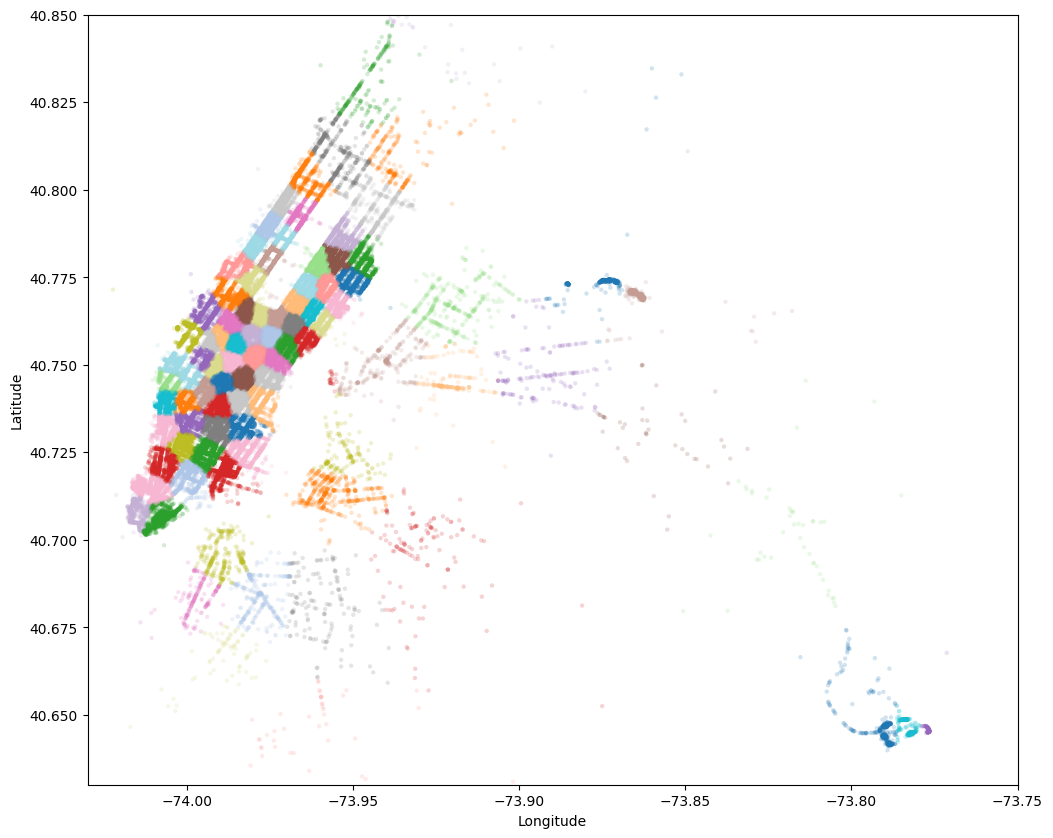

In [ ]:
def plot_clusters(frame):

    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 10)) # Added figsize for better visibility

    ax.scatter(frame.pickup_longitude.values[:100000],
               frame.pickup_latitude.values[:100000],
               s=10,
               lw=0,
               c=frame.pickup_cluster.values[:100000],
               cmap='tab20',
               alpha=0.2)

    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(cleaned_frame)

In [ ]:
import numpy as np

cleaned_frame['pickup_times'] = cleaned_frame['tpep_pickup_datetime'].astype(np.int64) // 10**9

In [ ]:
def add_pickup_bins(frame, month, year):

    unix_pickup_times = [i for i in frame['pickup_times'].values]

    unix_times = [
        [1420070400, 1422748800, 1425168000, 1427846400, 1430438400, 1433116800],
        [1451606400, 1454284800, 1456790400, 1459468800, 1462060800, 1464739200]
    ]

    start_pickup_unix = unix_times[year - 2015][month - 1]

    tenminutewise_binned_unix_pickup_times = [
        (int((i - start_pickup_unix) / 600) + 33) for i in unix_pickup_times
    ]

    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)

    return frame

# **5. Applying the Data Preparation Pipeline**

Now that our cleaning logic and K-Means model are established, we apply the complete pipeline to our target datasets.

### **Process Overview**
We use the `datapreparation()` function to process the raw data. For each dataset, the function performs the following steps automatically:
1.  **Time Calculation:** Converts pickup/dropoff timestamps into trip durations and calculates speed.
2.  **Outlier Removal:** Filters out trips with impossible speeds, coordinates outside NYC, or extreme fares.
3.  **Cluster Assignment:** Uses our trained K-Means model ($K=30$) to assign every pickup location to a specific cluster ID.
4.  **Temporal Binning:** Groups the data into 10-minute time slots (bins).

### **Output**
The final result is a structured dataset grouped by **Cluster ID** and **Time Bin**, ready for training our forecasting models.
* **Processed Months:** Jan 2015, Jan 2016, Feb 2016.

In [ ]:

!pip install gpxpy

import pandas as pd
import numpy as np
import dask.dataframe as dd
import gpxpy.geo
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import gc
import os

print("All libraries imported and installed.")

All libraries imported and installed.


In [ ]:

def remove_outliers(new_frame):

    cleaned_frame = new_frame[
        ((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &
         (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176) &
         (new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_longitude <= -73.7004) &
         (new_frame.pickup_latitude >= 40.5774) & (new_frame.pickup_latitude <= 40.9176)) &
        (new_frame.trip_times > 0) & (new_frame.trip_times < 720) &
        (new_frame.trip_distance > 0) & (new_frame.trip_distance < 23) &
        (new_frame.Speed <= 65) & (new_frame.Speed >= 0) &
        (new_frame.total_amount < 1000) & (new_frame.total_amount > 0)
    ]
    return cleaned_frame

def add_pickup_bins(frame, month, year):
    unix_pickup_times = [i for i in frame['pickup_times'].values]
    unix_times = [
        [1420070400, 1422748800, 1425168000, 1427846400, 1430438400, 1433116800],
        [1451606400, 1454284800, 1456790400, 1459468800, 1462060800, 1464739200]
    ]
    start_pickup_unix = unix_times[year - 2015][month - 1]
    tenminutewise_binned_unix_pickup_times = [
        (int((i - start_pickup_unix) / 600) + 33) for i in unix_pickup_times
    ]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame


def return_with_trip_times(frame):
    if hasattr(frame, 'compute'):
        frame = frame.compute()

    frame['tpep_pickup_datetime'] = pd.to_datetime(frame['tpep_pickup_datetime'])
    frame['tpep_dropoff_datetime'] = pd.to_datetime(frame['tpep_dropoff_datetime'])
    frame['trip_times'] = (frame['tpep_dropoff_datetime'] - frame['tpep_pickup_datetime']).dt.total_seconds() / 60
    frame['Speed'] = frame['trip_distance'] / (frame['trip_times'] / 60)
    frame['Speed'] = frame['Speed'].replace([np.inf, -np.inf], np.nan).fillna(0)
    frame['pickup_times'] = frame['tpep_pickup_datetime'].astype(np.int64) // 10**9
    return frame

def datapreparation(month, kmeans, month_no, year_no):
    print(f"  > Calculating metrics for {year_no}-{month_no}...")
    frame_with_durations = return_with_trip_times(month)

    print("  > Removing outliers...")
    frame_clean = remove_outliers(frame_with_durations)

    print("  > Predicting clusters...")
    frame_clean['pickup_cluster'] = kmeans.predict(frame_clean[['pickup_latitude', 'pickup_longitude']].values)

    print("  > Grouping by bins...")
    final_updated_frame = add_pickup_bins(frame_clean, month_no, year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster', 'pickup_bins', 'trip_distance']].groupby(['pickup_cluster', 'pickup_bins']).count()

    return final_updated_frame, final_groupby_frame

print("Functions Defined.")

Functions Defined.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import gc

print("Loading specialized data for K-Means...")
cols_to_load = ['pickup_latitude', 'pickup_longitude']
df_for_clustering = pd.read_csv('/content/nyc_taxi/yellow_tripdata_2015-01.csv', usecols=cols_to_load)


df_for_clustering = df_for_clustering[
    (df_for_clustering['pickup_latitude'] > 40) & (df_for_clustering['pickup_latitude'] < 42) &
    (df_for_clustering['pickup_longitude'] > -75) & (df_for_clustering['pickup_longitude'] < -72)
]

print("Sampling data...")
if len(df_for_clustering) > 500000:
    coords = df_for_clustering.sample(n=500000, random_state=42).values
else:
    coords = df_for_clustering.values

del df_for_clustering
gc.collect()

#use K=30 or 40 as they are optimal values from previous observations
print("Training KMeans Model (Use K=30)...")
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000, random_state=42).fit(coords)

print("Model Trained Successfully!")
print(f"Cluster Centers found: {len(kmeans.cluster_centers_)}")

import pickle
with open("kmeans_30.pkl", "wb") as f:
    pickle.dump(kmeans, f)
print("Model saved to 'kmeans_30.pkl'")

Loading specialized data for K-Means...
Sampling data...
Training KMeans Model (K=30)...
Model Trained Successfully!
Cluster Centers found: 30
Model saved to 'kmeans_30.pkl'


In [ ]:

import pandas as pd
print("Loading Jan 2015 for training...")
df_2015 = pd.read_csv('/content/nyc_taxi/yellow_tripdata_2015-01.csv')

df_2015 = return_with_trip_times(df_2015)
df_clean_2015 = remove_outliers(df_2015)

print("Training KMeans Model...")
coords = df_clean_2015[['pickup_latitude', 'pickup_longitude']].values
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000, random_state=42).fit(coords)

del df_2015
del df_clean_2015
del coords
gc.collect()

print("Model Trained and RAM cleared.")

Loading Jan 2015 for training...
Training KMeans Model...
Model Trained and RAM cleared.


In [ ]:
import dask.dataframe as dd
import pandas as pd
import gc

#for this project we will be using only Jan and Feb 2016 data and Jan 2015 data
dtype_fix = {'tip_amount': 'float64', 'tolls_amount': 'float64', 'total_amount': 'float64',
             'improvement_surcharge': 'float64', 'extra': 'float64', 'mta_tax': 'float64', 'fare_amount': 'float64'}

print("--- Processing JAN 2016 ---")
month_jan = dd.read_csv('/content/nyc_taxi/yellow_tripdata_2016-01.csv', dtype=dtype_fix)
jan_2016_frame, jan_2016_groupby = datapreparation(month_jan, kmeans, 1, 2016)

jan_2016_groupby.to_csv('jan_2016_grouped.csv')
print("Saved Jan.")


del month_jan
del jan_2016_frame
del jan_2016_groupby
gc.collect()

print("--- Processing FEB 2016 ---")
month_feb = dd.read_csv('/content/nyc_taxi/yellow_tripdata_2016-02.csv', dtype=dtype_fix)
feb_2016_frame, feb_2016_groupby = datapreparation(month_feb, kmeans, 2, 2016)

feb_2016_groupby.to_csv('feb_2016_grouped.csv')
print("Saved Feb.")

del month_feb
del feb_2016_frame
del feb_2016_groupby
gc.collect()

print("Done! You have processed Jan and Feb safely.")

In [ ]:
import pandas as pd
import dask.dataframe as dd
import gc
import os

if not os.path.exists('jan_2015_grouped.csv'):
    print("Generating Jan 2015 Grouped Data...")

    df_2015 = dd.read_csv('/content/nyc_taxi/yellow_tripdata_2015-01.csv')

    jan_2015_frame, jan_2015_groupby = datapreparation(df_2015, kmeans, 1, 2015)

    jan_2015_groupby.to_csv('jan_2015_grouped.csv')
    print("Saved jan_2015_grouped.csv")

    del df_2015
    del jan_2015_frame
    del jan_2015_groupby
    gc.collect()
else:
    print("jan_2015_grouped.csv already exists. Skipping generation.")

In [ ]:
import pandas as pd
import pickle
import gc
import os

print("Loading K-Means model...")
try:
    with open("kmeans_30.pkl", "rb") as f:
        kmeans = pickle.load(f)
    print("Model loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'kmeans_30.pkl' not found. Please train and save the model first.")
    exit()

files_to_process = [

    ('/content/nyc_taxi/yellow_tripdata_2016-01.csv', 'nyc_taxi_2016_01_clustered.csv'),
    ('/content/nyc_taxi/yellow_tripdata_2016-02.csv', 'nyc_taxi_2016_02_clustered.csv')
]


for input_path, output_name in files_to_process:

    if not os.path.exists(input_path):
        print(f"Skipping {input_path} (File not found)")
        continue

    print(f"\n--- Processing {input_path} ---")

    df = pd.read_csv(input_path)
    print(f"Loaded {len(df)} rows.")

    df = df[
        (df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42) &
        (df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -72)
    ]

    print("Assigning clusters...")
    df['pickup_cluster'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude']].values)
    df['dropoff_cluster'] = kmeans.predict(df[['dropoff_latitude', 'dropoff_longitude']].values)

    df.to_csv(output_name, index=False)
    print(f"Success! Saved to: {output_name}")

    del df
    gc.collect()

print("\nAll files processed!.")

In [ ]:
import pandas as pd

file_path = 'jan_2015_grouped.csv'
df_preview = pd.read_csv(file_path, nrows=5)

print("COLUMNS FOUND IN FILE:")
print(df_preview.columns.tolist())


print("\nFIRST ROW OF DATA:")
print(df_preview.head(1))

COLUMNS FOUND IN FILE:
['pickup_cluster', 'pickup_bins', 'trip_distance']

FIRST ROW OF DATA:
   pickup_cluster  pickup_bins  trip_distance
0               0           33            107


# **5. Time Series Smoothing**

### **The Problem: Zero-Demand Intervals**
In many regions, demand often drops to exactly **0** during off-peak hours.
Why "Zero" is DangerousWhile 0 pickups is a valid real-world observation, it breaks our feature engineering steps:The "Divide by Zero" Error: We will later create a Ratio Feature (Growth Rate) calculated as:$$Ratio = \frac{P_{t}}{P_{t-1}}$$The Crash: If $P_{t-1}$ (pickups in the previous 10 mins) is 0, this equation becomes infinity ($\infty$), causing the model to crash.

```text
  Pickups
     ^
  50 |          * *
     |         / \ / \
  25 |        /   * \
     |       /       \____/
   0 |------* ^^^^ ------- (Zero Demand!)
     +-------------------------> Time (10-min bins)

In [ ]:
import pandas as pd
import numpy as np
import os

def process_single_file(filename, year, smooth_data=False, window_size=3):
    """
    Loads one file, fills missing bins, and optionally smooths it.
    """
    print(f"\nProcessing {filename}...")


    if not os.path.exists(filename):
        print(f"⚠️ Warning: {filename} not found.")
        return None

    df = pd.read_csv(filename, usecols=['pickup_cluster', 'pickup_bins', 'trip_distance'])

    df = df.rename(columns={'trip_distance': 'ride_count', 'pickup_bins': 'time_bin'})

    max_bin = df['time_bin'].max()
    full_bin_range = range(0, int(max_bin) + 1)

    processed_frames = []

    for cluster_id, cluster_data in df.groupby('pickup_cluster'):


        cluster_data = cluster_data.set_index('time_bin')

        cluster_data = cluster_data[~cluster_data.index.duplicated(keep='first')]
        filled_data = cluster_data['ride_count'].reindex(full_bin_range, fill_value=0)

        temp_df = pd.DataFrame({'time_bin': filled_data.index, 'ride_count': filled_data.values})
        temp_df['pickup_cluster'] = cluster_id


        if smooth_data:
            temp_df['ride_count'] = temp_df['ride_count'].rolling(window=window_size, min_periods=1).mean()

        processed_frames.append(temp_df)

    result_df = pd.concat(processed_frames, ignore_index=True)
    result_df['year'] = year
    return result_df

df_jan_2015 = process_single_file('jan_2015_grouped.csv', year=2015, smooth_data=True)

df_jan_2016 = process_single_file('jan_2016_grouped.csv', year=2016, smooth_data=False)
df_feb_2016 = process_single_file('feb_2016_grouped.csv', year=2016, smooth_data=False)

dfs_to_combine = []
if df_jan_2015 is not None: dfs_to_combine.append(df_jan_2015)
if df_jan_2016 is not None: dfs_to_combine.append(df_jan_2016)
if df_feb_2016 is not None: dfs_to_combine.append(df_feb_2016)

if dfs_to_combine:
    final_dataset = pd.concat(dfs_to_combine, ignore_index=True)
    print("\n🎉 Success! Final dataset ready.")
    print(f"Total Rows: {len(final_dataset)}")
    print(final_dataset.head())
else:
    print("❌ Error: No data could be processed.")


Processing jan_2015_grouped.csv...

Processing jan_2016_grouped.csv...

Processing feb_2016_grouped.csv...

🎉 Success! Final dataset ready.
Total Rows: 396090
   time_bin  ride_count  pickup_cluster  year
0         0         0.0               0  2015
1         1         0.0               0  2015
2         2         0.0               0  2015
3         3         0.0               0  2015
4         4         0.0               0  2015


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the lengths of the months (Number of 10-min bins)
# Jan = 31 days * 24 hours * 6 bins = 4464
# Feb = 29 days (2016 was leap year) * 24 * 6 = 4176
len_jan = 4464
len_feb = 4176
regions_cum = []

print("Creating cumulative time series for 2016...")

for i in range(30):
    cluster_data = final_dataset[
        (final_dataset['pickup_cluster'] == i) &
        (final_dataset['year'] == 2016)
    ]

    jan_vals = cluster_data.iloc[0:len_jan]['ride_count'].values
    feb_vals = cluster_data.iloc[len_jan : len_jan+len_feb]['ride_count'].values

    combined = np.concatenate([jan_vals, feb_vals])

    regions_cum.append(combined)

print(f"Created regions_cum with {len(regions_cum)} clusters.")
print(f"Length of one cluster series: {len(regions_cum[0])} (Should be 4464 + 4176 = 8640)")

# **6. Periodicity Analysis (FFT)**

We apply the **Fast Fourier Transform (FFT)** to convert our time-series data into the Frequency Domain, revealing dominant repeating cycles in taxi demand.
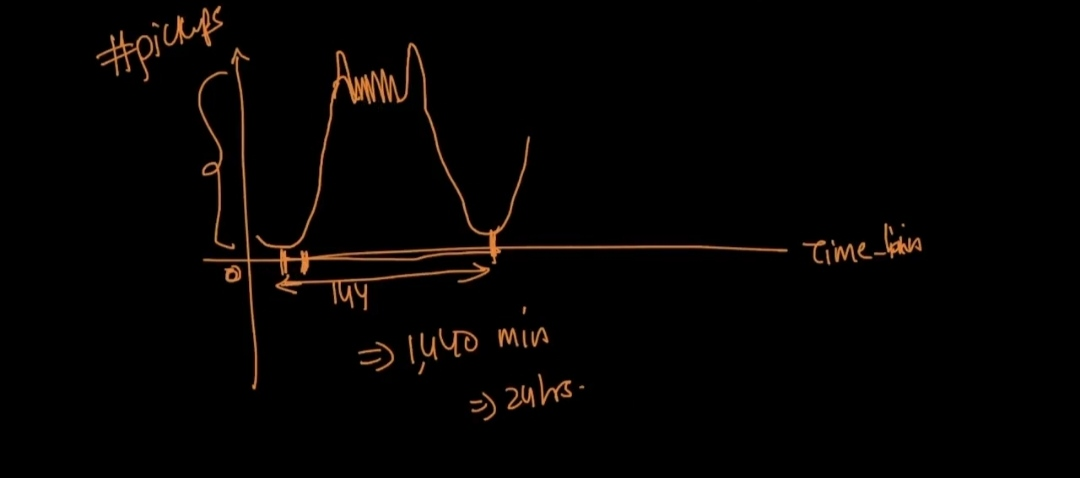

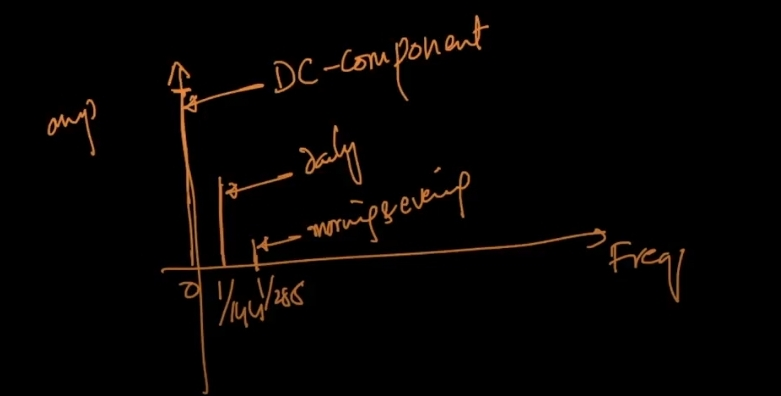

### **Key Observations**

1.  **DC Component (Frequency 0):**
    * We observe a massive peak at 0. This represents the **mean offset** (baseline demand), as taxi pickups are always positive and do not oscillate around zero.

2.  **Daily Cycle (Frequency $\approx$ 1/144):**
    * The most significant peak corresponds to the **24-hour cycle**.
    * **Math:** $24 \text{ hours} = 1440 \text{ mins}$. With **10-minute bins**, the period is $144$ bins ($1440/10$). Thus, frequency is $1/144$.
    * **Significance:** Captures the standard daily rise and fall of traffic.

3.  **48-Hour Cycle (Frequency $\approx$ 1/288):**
    * A smaller secondary peak appears at $1/288$ (half the daily frequency).
    * **Significance:** This captures **48-hour patterns**, reflecting variations between consecutive days (e.g., the transition from weekday to weekend).

In [ ]:
import plotly.graph_objects as go
import numpy as np

len_jan = 4464
len_feb = 4176

cluster_id = 0
data = regions_cum[cluster_id]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(0, len_jan)),
    y=data[0:len_jan],
    mode='lines',
    name='Jan 2016',
    line=dict(color='blue', width=1)
))

fig.add_trace(go.Scatter(
    x=list(range(len_jan, len_jan + len_feb)),
    y=data[len_jan : len_jan + len_feb],
    mode='lines',
    name='Feb 2016',
    line=dict(color='green', width=1)
))

fig.update_layout(
    title=f"Interactive Demand for Cluster {cluster_id}",
    xaxis_title="10-min Time Bins",
    yaxis_title="Ride Count",
    template="plotly_white",
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="linear"
    )
)

fig.show()

In [ ]:
import pandas as pd
import numpy as np
import math

df_2015 = final_dataset[final_dataset['year'] == 2015].copy()
df_2016 = final_dataset[final_dataset['year'] == 2016].copy()

df_2015 = df_2015.rename(columns={'ride_count': 'Given'})
df_2016 = df_2016.rename(columns={'ride_count': 'Prediction'})

ratios = pd.merge(df_2016, df_2015[['pickup_cluster', 'time_bin', 'Given']],
                  on=['pickup_cluster', 'time_bin'],
                  how='left')

ratios['Given'] = ratios['Given'].fillna(0)

ratios['Ratios'] = np.where(ratios['Given'] > 0,
                            ratios['Prediction'] / ratios['Given'],
                            0)

print("Data prepared for SMA models:")
print(ratios[['time_bin', 'pickup_cluster', 'Given', 'Prediction', 'Ratios']].head())

Data prepared for SMA models:
   time_bin  pickup_cluster  Given  Prediction  Ratios
0         0               0    0.0         0.0     0.0
1         1               0    0.0         0.0     0.0
2         2               0    0.0         0.0     0.0
3         3               0    0.0         0.0     0.0
4         4               0    0.0         0.0     0.0


# **7. Feature Engineering: Mathematical Formulas**

To predict the pickups at time $t$ (denoted as $P_t$), we use two types of inputs:
1.  **Raw Pickups ($P$):** Using previous values directly ($P_{t-1}, P_{t-2} \dots$).
2.  **Ratio Features ($R$):** Using the growth ratio relative to last year's data ($P^{2015}_t$).

### **The Ratio Definition**
$$R_t = \frac{P_t^{2016}}{P_t^{2015}}$$
* If we predict the ratio $\hat{R}_t$, the final pickup prediction is: $\hat{Y}_t = \hat{R}_t \times P_t^{2015}$.

---

## **1. Simple Moving Average (SMA)**
*The average of the last $N$ values.*

**A. SMA for Pickups ($SMA\_P$)**
$$\hat{Y}_t = \frac{P_{t-1} + P_{t-2} + \dots + P_{t-n}}{n}$$

**B. SMA for Ratios ($SMA\_R$)**
$$\hat{R}_t = \frac{R_{t-1} + R_{t-2} + \dots + R_{t-n}}{n}$$
$$\text{Final Prediction: } \hat{Y}_t = \hat{R}_t \times P_t^{2015}$$

> **Note:** We do not guess $n$. We test multiple window sizes ($n=1, 2, 3 \dots$) and select the $n$ that yields the **lowest MAPE**.

---

## **2. Weighted Moving Average (WMA)**
*Recent values get higher weight ($n$), while older values get lower weight ($1$).*

**C. WMA for Pickups ($WMA\_P$)**
$$\hat{Y}_t = \frac{n(P_{t-1}) + (n-1)(P_{t-2}) + \dots + 1(P_{t-n})}{n(n+1)/2}$$

**D. WMA for Ratios ($WMA\_R$)**
$$\hat{R}_t = \frac{n(R_{t-1}) + (n-1)(R_{t-2}) + \dots + 1(R_{t-n})}{n(n+1)/2}$$
$$\text{Final Prediction: } \hat{Y}_t = \hat{R}_t \times P_t^{2015}$$

> **Note:** Just like SMA, the optimal window size $n$ is chosen based on the **least MAPE**.

---

## **3. Exponential Weighted Moving Average (EWMA)**
*A recursive formula that adjusts based on the previous error.*

**E. EWMA for Pickups ($EWMA\_P$)**
$$\hat{Y}_t = \alpha \cdot P_{t-1} + (1-\alpha) \cdot \hat{Y}_{t-1}$$

**F. EWMA for Ratios ($EWMA\_R$)**
$$\hat{R}_t = \alpha \cdot R_{t-1} + (1-\alpha) \cdot \hat{R}_{t-1}$$
$$\text{Final Prediction: } \hat{Y}_t = \hat{R}_t \times P_t^{2015}$$

### **Why EWMA is Powerful:**
Unlike SMA/WMA which only look at raw past data, EWMA uses:
1.  The **Actual** previous value ($R_{t-1}$)
2.  The **Predicted** previous value ($\hat{R}_{t-1}$)

By comparing these two, the formula effectively "checks the error" of the previous prediction (how bad was our last guess?) and uses that information to adjust the forecast for the next step.

In [ ]:
def MA_R_Predictions(ratios, window_size=3):
    """
    Calculates prediction based on Moving Average of Ratios.
    Formula: R_t = (R_{t-1} + R_{t-2} + ... + R_{t-n}) / n
    Prediction = R_t * Given_Value_2015
    """
    predicted_ratio = (ratios['Ratios'].values)[0]
    error = []
    predicted_values = []
    predicted_ratio_values = []

    limit = len(ratios)

    print(f"Running MA_R (Ratios) with window={window_size}...")

    ratios_arr = ratios['Ratios'].values
    given_arr = ratios['Given'].values
    actual_arr = ratios['Prediction'].values

    for i in range(limit):
        if i % 4464 == 0 and i != 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            predicted_ratio = 0
            continue

        predicted_ratio_values.append(predicted_ratio)

        pred_val = int(given_arr[i] * predicted_ratio)
        predicted_values.append(pred_val)

        err = abs(pred_val - actual_arr[i])
        error.append(err)

        if i + 1 >= window_size:
            predicted_ratio = sum(ratios_arr[(i + 1) - window_size : (i + 1)]) / window_size
        else:
            predicted_ratio = sum(ratios_arr[0 : (i + 1)]) / (i + 1)

    mape_err = (sum(error)/len(error)) / (sum(actual_arr)/len(actual_arr))
    mse_err = sum([e**2 for e in error]) / len(error)

    return predicted_values, map_err, mse_err


Preparing data for Moving Averages...
Data ready. Rows: 261180
Running SMA (Simple Moving Average)...
Running WMA (Weighted Moving Average)...
Running EWMA (Exponential Moving Average)...

Calculating metrics...

🏆 FINAL MODEL LEADERBOARD 🏆
 Model   MAPE (%)         MSE
EWMA_R 100.047081 1498.926252
EWMA_P 100.165416 1436.686204
 SMA_P 108.288248 1717.925752
 SMA_R 108.985939 1778.247084
 WMA_P 112.060857 1875.867419
 WMA_R 113.316955 1924.246329


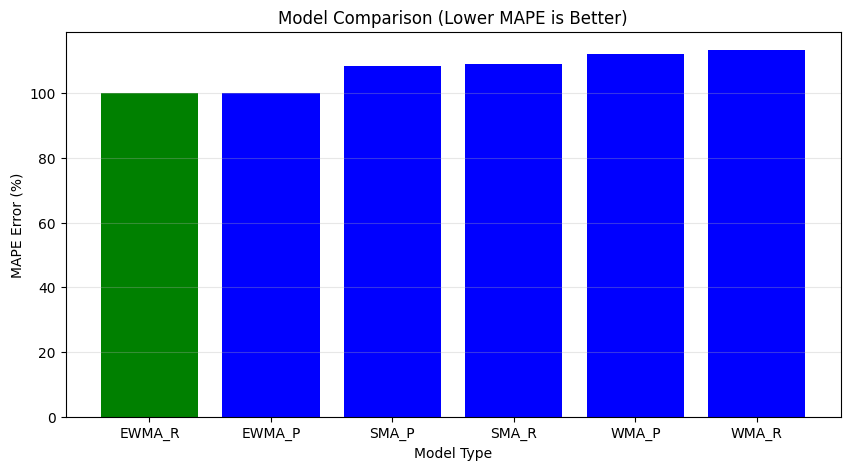

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

print("Preparing data for Moving Averages...")

if 'final_dataset' not in locals():
    print("❌ Error: 'final_dataset' not found. Please run the smoothing steps first.")
else:
    df_2015 = final_dataset[final_dataset['year'] == 2015].copy().rename(columns={'ride_count': 'Given'})
    df_2016 = final_dataset[final_dataset['year'] == 2016].copy().rename(columns={'ride_count': 'Actual'})

    ratios = pd.merge(df_2016, df_2015[['pickup_cluster', 'time_bin', 'Given']],
                      on=['pickup_cluster', 'time_bin'], how='left')

    ratios['Given'] = ratios['Given'].fillna(0)

    ratios['Ratio_Actual'] = np.where(ratios['Given'] > 0,
                                      ratios['Actual'] / ratios['Given'],
                                      0)

    ratios = ratios.sort_values(by=['pickup_cluster', 'time_bin'])
    print(f"Data ready. Rows: {len(ratios)}")

def calculate_sma(df, window=3):
    """Simple Moving Average for Previous Values (P) and Ratios (R)"""
    grouped = df.groupby('pickup_cluster')

    df['SMA_P'] = grouped['Actual'].shift(1).rolling(window=window, min_periods=1).mean()

    df['Smooth_Ratio'] = grouped['Ratio_Actual'].shift(1).rolling(window=window, min_periods=1).mean()
    df['SMA_R'] = df['Smooth_Ratio'] * df['Given']

    return df.fillna(0)

def calculate_wma(df, weights=[0.5, 0.3, 0.2]):
    """Weighted Moving Average (Window=3)"""
    grouped = df.groupby('pickup_cluster')

    t1 = grouped['Actual'].shift(1).fillna(0)
    t2 = grouped['Actual'].shift(2).fillna(0)
    t3 = grouped['Actual'].shift(3).fillna(0)

    df['WMA_P'] = (t1 * weights[0]) + (t2 * weights[1]) + (t3 * weights[2])

    r1 = grouped['Ratio_Actual'].shift(1).fillna(0)
    r2 = grouped['Ratio_Actual'].shift(2).fillna(0)
    r3 = grouped['Ratio_Actual'].shift(3).fillna(0)

    smooth_w_ratio = (r1 * weights[0]) + (r2 * weights[1]) + (r3 * weights[2])
    df['WMA_R'] = smooth_w_ratio * df['Given']

    return df

def calculate_ewma(df, span=5):
    """Exponential Weighted Moving Average"""
    grouped = df.groupby('pickup_cluster')

    df['EWMA_P'] = grouped['Actual'].shift(1).ewm(span=span, adjust=False).mean()

    smooth_ewma_ratio = grouped['Ratio_Actual'].shift(1).ewm(span=span, adjust=False).mean()
    df['EWMA_R'] = smooth_ewma_ratio * df['Given']

    return df.fillna(0)

print("Running SMA (Simple Moving Average)...")
ratios = calculate_sma(ratios, window=3)

print("Running WMA (Weighted Moving Average)...")
ratios = calculate_wma(ratios, weights=[0.5, 0.3, 0.2])

print("Running EWMA (Exponential Moving Average)...")
ratios = calculate_ewma(ratios, span=5)

def get_metrics(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100
    mse = mean_squared_error(y_true, y_pred)
    return mape, mse

models = ['SMA_P', 'WMA_P', 'EWMA_P', 'SMA_R', 'WMA_R', 'EWMA_R']
results = []
y_true = ratios['Actual']

print("\nCalculating metrics...")
for model in models:
    mape, mse = get_metrics(y_true, ratios[model])
    results.append({'Model': model, 'MAPE (%)': mape, 'MSE': mse})

leaderboard = pd.DataFrame(results).sort_values(by='MAPE (%)', ascending=True)

print("\n" + "="*40)
print("🏆 FINAL MODEL LEADERBOARD 🏆")
print("="*40)
print(leaderboard.to_string(index=False))

plt.figure(figsize=(10, 5))
colors = ['green' if x == leaderboard.iloc[0]['Model'] else 'blue' for x in leaderboard['Model']]
plt.bar(leaderboard['Model'], leaderboard['MAPE (%)'], color=colors)
plt.title('Model Comparison (Lower MAPE is Better)')
plt.ylabel('MAPE Error (%)')
plt.xlabel('Model Type')
plt.grid(axis='y', alpha=0.3)
plt.show()

# **8. Modeling Strategy**

With our features engineered (Moving Averages, Ratios) and data smoothed, we now proceed to training predictive models.

### **The Goal**
To predict the **number of pickups** for a specific cluster in the next 10-minute time bin.

### **Models to be Evaluated**
We will train and compare the performance of the following models, ranging from simple baselines to advanced ensemble methods:

| Model Type | Description |
| :--- | :--- |
| **1. Baseline Model** | A simple non-parametric approach (e.g., Simple Moving Average or naive previous-value logic) to establish a minimum performance benchmark. |
| **2. Exponential Averages Forecasting** | A dedicated statistical method (EWMA) that weighs recent data more heavily to capture short-term trends dynamically. |
| **3. Linear Regression** | A simple interpretable model to establish a linear relationship between our engineered features and the target. |
| **4. Random Forest Regression** | A bagging ensemble method that trains multiple decision trees in parallel to capture non-linear patterns and reduce overfitting. |
| **5. XGBoost Regression** | A boosting ensemble method (Extreme Gradient Boosting) that builds trees sequentially, correcting errors of previous trees. Known for high performance in large datasets. |

### **Evaluation Metric**
We will judge all models based on **MAPE (Mean Absolute Percentage Error)** and **MSE (Mean Squared Error)** to ensure our predictions are close to the actual demand values.

In [ ]:
import pandas as pd
import numpy as np

def prepare_model_data(df):

    df = df.sort_values(by=['pickup_cluster', 'time_bin'])

    for i in range(1, 6):
        df[f'ft_{i}'] = df.groupby('pickup_cluster')['ride_count'].shift(i)

    if 'tpep_pickup_datetime' in df.columns:
        df['weekday'] = df['tpep_pickup_datetime'].dt.weekday
    else:
        df['weekday'] = (df['time_bin'] // (24*6)) % 7

    if 'EWMA_P' in df.columns:
        df['exp_avg'] = df['EWMA_P']
    else:
        df['exp_avg'] = df.groupby('pickup_cluster')['ride_count'].shift(1).ewm(span=5).mean()

    df['lat'] = 40.7
    df['lon'] = -74.0

    df = df.dropna()

    return df

print("Preparing features...")
final_dataset = prepare_model_data(final_dataset)

features = ['ft_1', 'ft_2', 'ft_3', 'ft_4', 'ft_5', 'lat', 'lon', 'weekday', 'exp_avg']
target = 'ride_count'

train_df = final_dataset[final_dataset['year'] == 2015]
test_df = final_dataset[final_dataset['year'] == 2016]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

print(f"Training Features: {X_train.shape}")
print(f"Testing Features: {X_test.shape}")

Preparing features...
Training Features: (134850, 9)
Testing Features: (261090, 9)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prettytable import PrettyTable


print("Preparing Features...")

final_dataset = final_dataset.sort_values(by=['pickup_cluster', 'time_bin'])

for i in range(1, 6):
    final_dataset[f'ft_{i}'] = final_dataset.groupby('pickup_cluster')['ride_count'].shift(i)

if 'tpep_pickup_datetime' in final_dataset.columns:
    final_dataset['weekday'] = final_dataset['tpep_pickup_datetime'].dt.weekday
else:
    final_dataset['weekday'] = (final_dataset['time_bin'] // (24*6)) % 7

final_dataset['exp_avg'] = final_dataset.groupby('pickup_cluster')['ride_count'].shift(1).ewm(span=5).mean()

final_dataset['SMA_P'] = final_dataset.groupby('pickup_cluster')['ride_count'].shift(1).rolling(window=3).mean()

final_dataset['lat'] = 40.7
final_dataset['lon'] = -74.0

model_data = final_dataset.dropna()

train_df = model_data[model_data['year'] == 2015]
test_df = model_data[model_data['year'] == 2016]

features = ['ft_1', 'ft_2', 'ft_3', 'ft_4', 'ft_5', 'lat', 'lon', 'weekday', 'exp_avg']
target = 'ride_count'

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"Data Prepared. Training on {len(X_train)} rows.")

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1)))

y_pred_base_train = train_df['SMA_P']
y_pred_base_test = test_df['SMA_P']
base_train_mape = calculate_mape(y_train, y_pred_base_train)
base_test_mape = calculate_mape(y_test, y_pred_base_test)

y_pred_exp_train = train_df['exp_avg']
y_pred_exp_test = test_df['exp_avg']
exp_train_mape = calculate_mape(y_train, y_pred_exp_train)
exp_test_mape = calculate_mape(y_test, y_pred_exp_test)


print("Training Linear Regression...")
lr_reg = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1)
lr_reg.fit(X_train, y_train)

# Predict Test
y_pred = lr_reg.predict(X_test)
lr_test_predictions = [round(value) for value in y_pred]
lr_test_mape = calculate_mape(y_test, lr_test_predictions)

# Predict Train
y_pred_train = lr_reg.predict(X_train)
lr_train_predictions = [round(value) for value in y_pred_train]
lr_train_mape = calculate_mape(y_train, lr_train_predictions)


print("Training Random Forest...")

regr1 = RandomForestRegressor(
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=3,
    n_estimators=40,
    n_jobs=-1,
    random_state=42
)
regr1.fit(X_train, y_train)

# Predict Test
y_pred = regr1.predict(X_test)
rndf_test_predictions = [round(value) for value in y_pred]
rf_test_mape = calculate_mape(y_test, rndf_test_predictions)

# Predict Train
y_pred_train = regr1.predict(X_train)
rndf_train_predictions = [round(value) for value in y_pred_train]
rf_train_mape = calculate_mape(y_train, rndf_train_predictions)


print("Training XGBoost...")

x_model = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=3,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=200,
    reg_lambda=200,
    nthread=4,
    objective='reg:squarederror'
)
x_model.fit(X_train, y_train)

# Predict Test
y_pred = x_model.predict(X_test)
xgb_test_predictions = [round(value) for value in y_pred]
xgb_test_mape = calculate_mape(y_test, xgb_test_predictions)

# Predict Train
y_pred_train = x_model.predict(X_train)
xgb_train_predictions = [round(value) for value in y_pred_train]
xgb_train_mape = calculate_mape(y_train, xgb_train_predictions)

print("\n" + "="*80)
print("Error Metric Matrix (Tree Based Regression Methods) - MAPE")
print("="*80)

table = PrettyTable()
table.field_names = ["Model", "Train MAPE", "Test MAPE"]
table.align = "l"

table.add_row(["Baseline Model", round(base_train_mape, 5), round(base_test_mape, 5)])
table.add_row(["Exponential Averages Forecasting", round(exp_train_mape, 5), round(exp_test_mape, 5)])
table.add_row(["Linear Regression", round(lr_train_mape, 5), round(lr_test_mape, 5)])
table.add_row(["Random Forest Regression", round(rf_train_mape, 5), round(rf_test_mape, 5)])
table.add_row(["XgBoost Regression", round(xgb_train_mape, 5), round(xgb_test_mape, 5)])

print(table)
print("="*80)

Preparing Features...
Data Prepared. Training on 134790 rows.
Training Linear Regression...
Training Random Forest...
Training XGBoost...

Error Metric Matrix (Tree Based Regression Methods) - MAPE
+----------------------------------+------------+-----------+
| Model                            | Train MAPE | Test MAPE |
+----------------------------------+------------+-----------+
| Baseline Model                   | 0.64925    | 1.14014   |
| Exponential Averages Forecasting | 0.81118    | 1.3448    |
| Linear Regression                | 0.20073    | 0.35175   |
| Random Forest Regression         | 0.08443    | 0.55497   |
| XgBoost Regression               | 0.13047    | 0.38275   |
+----------------------------------+------------+-----------+
